In [104]:
import struct
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def read_info(filename):
    
    info = {}

    with open(filename, "r") as file:
        for line in file:

            if "=" in line:
                key, value = line.split("=")
                key = key.strip()     # remove whitespace
                value = value.strip() # remove whitespace

                try:
                    if "." in value:
                        value = float(value)

                    else:
                        value = int(value)

                except ValueError:
                    pass # leave the value as a string

                info[key] = value
                
    return info

In [3]:
def read_header(file):
    """
    Reads a padded value from a binary file.
    Each block contains [header_size][value][tail_size].
    """
    header_size = struct.unpack('i', file.read(4))[0]
    
    if   header_size ==  4: value = struct.unpack('i', file.read(header_size))[0]
    elif header_size ==  8: value = struct.unpack('q', file.read(header_size))[0]
    elif header_size == 16: value = struct.unpack('4i', file.read(header_size))
    else:
        raise ValueError(f"Unexpected header size: {header_size} bytes")
    
    tail_size = struct.unpack('i', file.read(4))[0]
    
    if header_size != tail_size:
        raise ValueError(f"Size mismatch: header_size={header_size}, tail_size={tail_size}")
    
    return value

In [4]:
def read_data(file, npart, dtype=np.float64):
    header_size = struct.unpack('i', file.read(4))[0]
    data = np.fromfile(file, dtype=dtype, count=npart)
    tail_size = struct.unpack('i', file.read(4))[0]
    
    if header_size != tail_size:
        raise ValueError(f"Size mismatch: header_size={header_size}, tail_size={tail_size}")
    
    return data

In [5]:
def get_output(filename, fields=None):
    
    data = {}

    with open(filename, 'rb') as file:
        """
        output_part.f90:
        ! Write header
          write(ilun)ncpu
          write(ilun)ndim
          write(ilun)npart #per MPI rank
          write(ilun)localseed
          write(ilun)nstar_tot #in total box
          write(ilun)mstar_tot #in total box
          write(ilun)mstar_lost
          write(ilun)nsink # bh
        """

        # Read all header values
        ncpu = read_header(file)
        ndim = read_header(file)
        npart = read_header(file)
        localseed = read_header(file)
        nstar_tot = read_header(file)
        mstar_tot = read_header(file)
        mstar_lost = read_header(file)
        nsink = read_header(file)

        # Save header information
        data['header'] = {
            'ncpu': ncpu,
            'ndim': ndim,
            'npart': npart,
            'localseed': localseed,
            'nstar_tot': nstar_tot,
            'mstar_tot': mstar_tot,
            'mstar_lost': mstar_lost,
            'nsink': nsink
        }


        # Read data
        positions = np.zeros((npart, ndim))
        positions[:, 0] = read_data(file, npart, dtype=np.float64)
        positions[:, 1] = read_data(file, npart, dtype=np.float64)
        positions[:, 2] = read_data(file, npart, dtype=np.float64)
        data['positions'] = positions

        velocities = np.zeros((npart, ndim))
        velocities[:, 0] = read_data(file, npart, dtype=np.float64)
        velocities[:, 1] = read_data(file, npart, dtype=np.float64)
        velocities[:, 2] = read_data(file, npart, dtype=np.float64)
        data['velocities'] = velocities

        data['masses']  = read_data(file, npart, dtype=np.float64)
        data['ids']     = read_data(file, npart, dtype=np.int64)
        data['levels']  = read_data(file, npart, dtype=np.int32)
        data['phi']      = read_data(file, npart, dtype=np.float64)
        data['tc_birth'] = read_data(file, npart, dtype=np.float64)
        data['metal']    = read_data(file, npart, dtype=np.float64)
        data['tp_birth'] = read_data(file, npart, dtype=np.float64)
        data['masses0']  = read_data(file, npart, dtype=np.float64)
        data['indtab']   = read_data(file, npart, dtype=np.float64)

    # If specific fields are requested, filter data
    if fields:
        filtered_data = {field: data[field] for field in fields if field in data}
        return filtered_data
    
    return data


# Load table

In [6]:
w0 = -1
wa = 0

sign_w0 = '+' if w0 >= 0 else ''
sign_wa = '+' if wa >= 0 else ''

fname_table = "/md/gilee/cosmos-in-us/Multiverse-utils/notebooks/friedmann/"
fname_table+= f"time_table_cpl{sign_w0}{w0:.1f}{sign_wa}{wa:.1f}.csv"

print(fname_table)

/md/gilee/cosmos-in-us/Multiverse-utils/notebooks/friedmann/time_table_cpl-1.0+0.0.csv


In [7]:
# with open(fname_table, "r") as file:
#     lines = file.readlines()
# lines

In [8]:
table = pd.read_csv(fname_table, skiprows=4, names=['t', 'tau0', 'tau1', 'a'])
table = table.dropna()

In [9]:
table

,t,tau0,tau1,a
0,1.000000e-08,1.000000e-08,1.000000e-08,1.000000
1,1.002005e-08,1.002005e-08,1.002005e-08,1.000000
2,1.004014e-08,1.004014e-08,1.004014e-08,1.000000
3,1.006028e-08,1.006028e-08,1.006028e-08,1.000000
4,1.008045e-08,1.008045e-08,1.008045e-08,1.000000
...,...,...,...,...
9782,1.002562e+00,3.237304e+00,5.352141e+01,0.004559
9783,1.002602e+00,3.243795e+00,5.498120e+01,0.004338
9784,1.002641e+00,3.250300e+00,5.651943e+01,0.004122
9785,1.002679e+00,3.256818e+00,5.814261e+01,0.003911


# Info

In [10]:
snapNum = 101

basePath = f"/md/gilee/cosmos-in-us/Multiverse-utils/notebooks/read_particle/lmin07-hr5-32-01-grammar/output_{snapNum:05d}"
# basePath = f"/md/gilee/cosmos-in-us/Multiverse-utils/notebooks/read_particle/lmin07-lcdm-32-01-grammar/output_{snapNum:05d}"
# basePath = f"/md/gilee/cosmos-in-us/Multiverse-utils/notebooks/read_particle/lmin07-cpl0-32-01-grammar/output_{snapNum:05d}"

In [11]:
info = read_info(f"{basePath}/info_{snapNum:05d}.txt")

In [ ]:
info

In [ ]:
ncpu = info['ncpu']
ndim = info['ndim']
nstep = info['nstep_coarse']

boxlen = info['boxlen'] # side length of a simulation box
unit_l = info['unit_l'] # side length of a simulation box in cm
unit_d = info['unit_d'] # volume mean density in g/cm^3
unit_t = info['unit_t'] # Aexp^2 / (H0/3.08 * 10^19) ?

levelmin = info['levelmin']
levelmax = info['levelmax']

time = info['time']
aexp = info['aexp']

H0 = info['H0'] # km/s/Mpc
h = H0 / 100

# Code unit

### Time

In [ ]:
Mpc_to_km = 206265 * 1.496 * 1e14
Mpc_to_cm = Mpc_to_km * 1e5

invH0_to_sec = Mpc_to_km # H0 [km/s/Mpc] --> [km/s/km] --> [1/s]
invH0_to_Gyr = invH0_to_sec / 3600 / 24 / 365 / 1e9

unit_t = 1/H0 * invH0_to_Gyr

In [ ]:
Mpc_to_cm

In [ ]:
print(unit_t)

### Length

In [ ]:
dx_fin_kpc = 1 # kpc

# Box size calculation
n_cell0    = 2**levelmin              # initial number of cell
c_Lbox_kpc = 2**levelmax * dx_fin_kpc # [ckpc] comoving box size
c_Lbox_Mpc = c_Lbox_kpc/1000          # [cMpc] comoving box size

In [18]:
print(levelmin)
print(c_Lbox_Mpc) # Mpc

7
16.384


In [19]:
boxlen * unit_l / Mpc_to_cm # why is it different? it should be equal to the box size

16.35649835276242

In [20]:
boxlen * unit_l / Mpc_to_cm / c_Lbox_Mpc # ~ 4 times larger

0.9983214326637219

### Mass

In [21]:
Msun_to_g = 1.989e33

unit_m = unit_d * unit_l**3 / Msun_to_g # [Msun]
unit_m

163709325932880.53

# Load particle data

In [22]:
npart_tot = 0

for icpu in range(1, ncpu+1):
    filename = f"{basePath}/part_{snapNum:05d}.out{icpu:05d}"
    data = get_output(filename, fields=['header'])
    npart_tot += data['header']['npart']

print(f"{npart_tot:,.0f}")

3,955,713


How can I distinguish stellar / DM particles here?

<IPython.core.display.Javascript object>


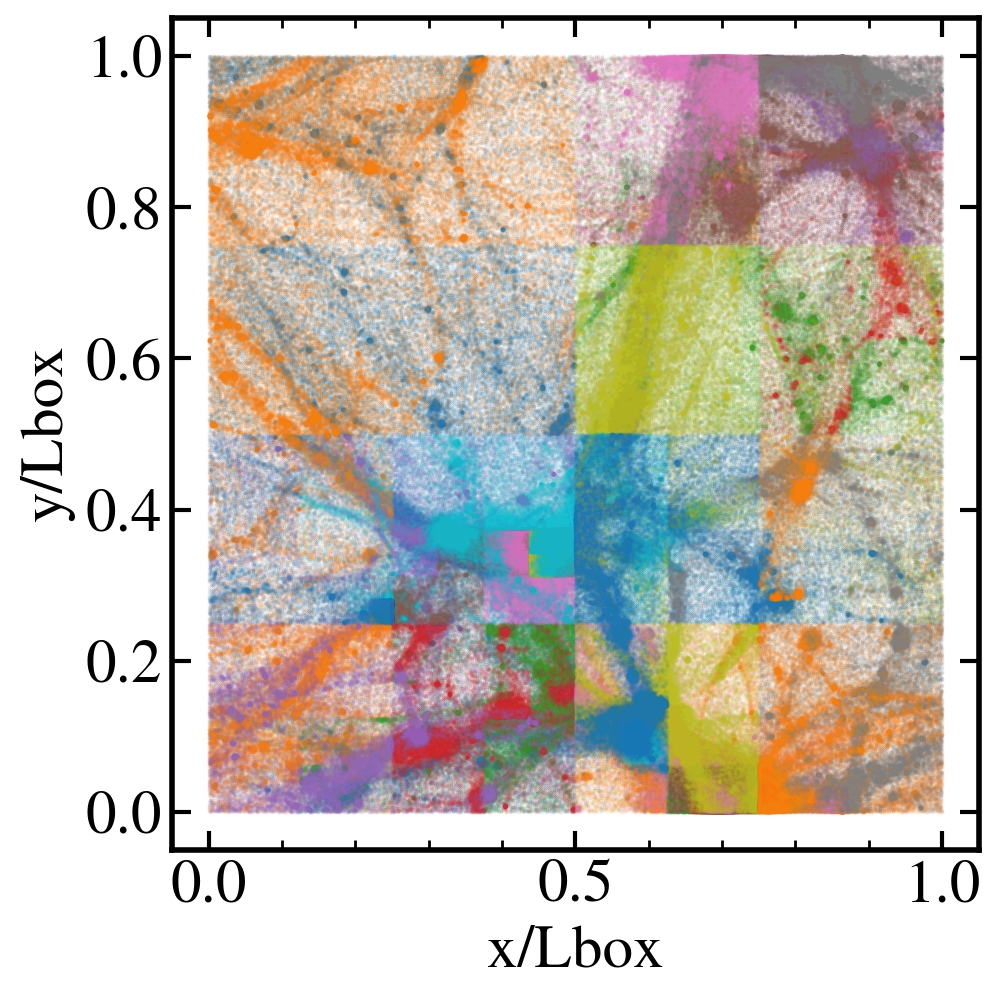

0 135169
135169 229000
229000 353365
353365 463184
463184 590624
590624 751654
751654 876039
876039 1016235
1016235 1108951
1108951 1254077
1254077 1380182
1380182 1513874
1513874 1613688
1613688 1738214
1738214 1821796
1821796 1942948
1942948 2067851
2067851 2180071
2180071 2294193
2294193 2385235
2385235 2499555
2499555 2633063
2633063 2785587
2785587 2916705
2916705 3168738
3168738 3299332
3299332 3403250
3403250 3510686
3510686 3633787
3633787 3753285
3753285 3851997
3851997 3955713


In [23]:
plt.figure(figsize=(5, 5))

npart = np.zeros(ncpu, dtype=np.int64)
pos = np.zeros((npart_tot, ndim), dtype=np.float64)
vel = np.zeros((npart_tot, ndim), dtype=np.float64)
pid = np.zeros(npart_tot, dtype=np.int64)
levels = np.zeros(npart_tot, dtype=np.int32)
masses0 = np.zeros(npart_tot, dtype=np.float64)
masses  = np.zeros(npart_tot, dtype=np.float64)
tp_birth = np.zeros(npart_tot, dtype=np.float64)
tc_birth = np.zeros(npart_tot, dtype=np.float64)

for icpu in range(ncpu):
    filename = f"{basePath}/part_{snapNum:05d}.out{icpu+1:05d}"
    data = get_output(filename)
    
    npart[icpu] = data['header']['npart']
    
    plt.scatter(data['positions'][:, 0], data['positions'][:, 1], s=0.1, alpha=0.1)
        
    i = np.sum(npart[:icpu])
    j = np.sum(npart[:icpu+1])
    print(i, j)
    
    pid[i:j] = data['ids']
    
    pos[i:j, 0] = data['positions'][:, 0]
    pos[i:j, 1] = data['positions'][:, 1]
    pos[i:j, 2] = data['positions'][:, 2]
    
    vel[i:j, 0] = data['velocities'][:, 0]
    vel[i:j, 1] = data['velocities'][:, 1]
    vel[i:j, 2] = data['velocities'][:, 2]
    
    levels[i:j] = data['levels']
    
    masses[i:j]  = data['masses']
    masses0[i:j] = data['masses0']
    
    tp_birth[i:j] = data['tp_birth']
    tc_birth[i:j] = data['tc_birth']

plt.xlabel("x/Lbox")
plt.ylabel("y/Lbox")
plt.tight_layout(pad=0.3)

In [25]:
np.cumsum(npart)

array([ 135169,  229000,  353365,  463184,  590624,  751654,  876039,
       1016235, 1108951, 1254077, 1380182, 1513874, 1613688, 1738214,
       1821796, 1942948, 2067851, 2180071, 2294193, 2385235, 2499555,
       2633063, 2785587, 2916705, 3168738, 3299332, 3403250, 3510686,
       3633787, 3753285, 3851997, 3955713])

In [26]:
# from matplotlib import cm
# from matplotlib.colors import Normalize

# plt.subplots(figsize=(5, 5))

# # Normalize the levels for colormap
# norm = Normalize(vmin=7, vmax=14)
# cmap = cm.viridis  # You can choose other colormaps like 'plasma', 'inferno', etc.

# scatter = plt.scatter(pos[:, 0], pos[:, 1], s=0.1, c=levels, cmap=cmap, norm=norm, alpha=0.1)
# plt.axis('equal')
# plt.xlabel("x / Lbox")
# plt.ylabel("y / Lbox")
# plt.subplots_adjust(bottom=0.155, left=0.155, top=0.99, right=0.99)

<IPython.core.display.Javascript object>


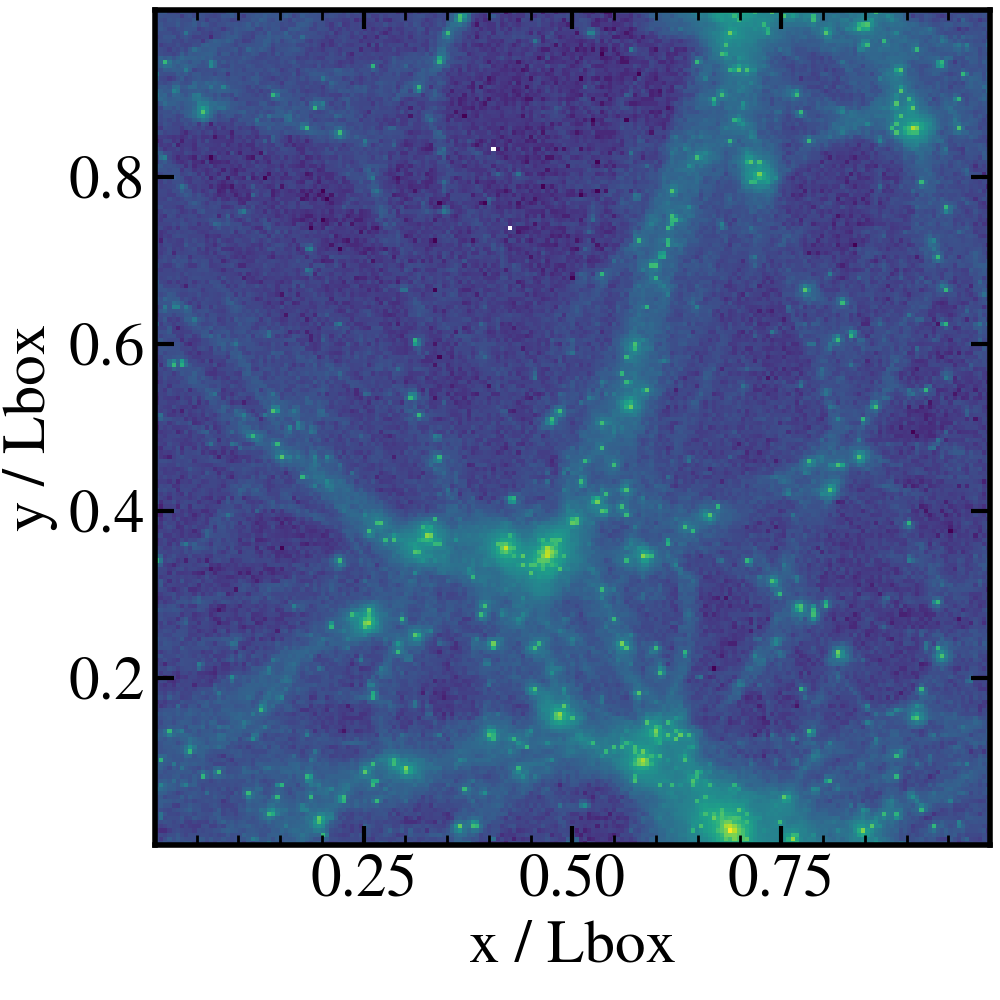

In [27]:
plt.subplots(figsize=(5, 5))
# plt.scatter(pos[:, 0], pos[:, 1], s=0.1, c='k', alpha=0.1)
plt.hist2d(pos[:, 0], pos[:, 1], norm=mpl.colors.LogNorm(), bins=201)
plt.axis('equal')
plt.xlabel("x / Lbox")
plt.ylabel("y / Lbox")
plt.subplots_adjust(bottom=0.155, left=0.155, top=0.99, right=0.99)

# Star Formation History (conformal time)

In [28]:
# tc_birth # conformal time [1/H0]
# tp_birth # proper time [1/H0]

In [29]:
len(np.where(tp_birth == 0)[0]) # DM + BH particles

3189614

In [30]:
len(np.where(pid < 0)[0]) # BH particles

1092462

In [31]:
len(np.where(tp_birth == 0)[0]) - len(np.where(pid < 0)[0]) # DM particles

2097152

In [32]:
(2**levelmin)**3 # initial DM particle number (should be same with the above number)

2097152

In [33]:
dm   = np.where((tp_birth==0) & (pid>0))[0]
bh   = np.where(pid < 0)[0]
star = np.where(tp_birth != 0)[0]

In [34]:
len(pid)

3955713

In [35]:
len(dm) + len(bh) + len(star) # should be same with `len(pid)`

3955713

In [36]:
pid_dm = pid[dm]
pid_bh = pid[bh]
pid_star = pid[star]

<IPython.core.display.Javascript object>


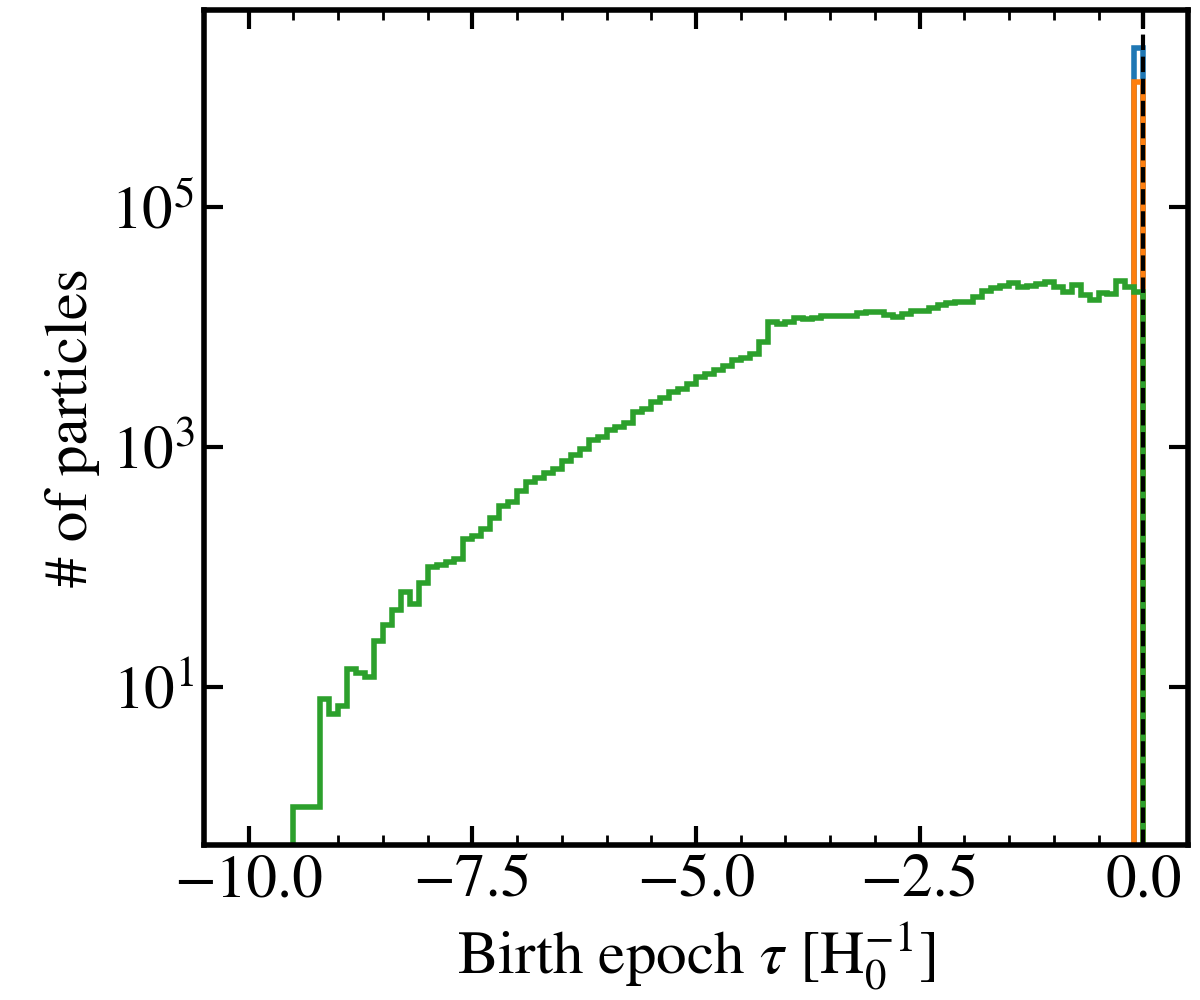

In [37]:
plt.subplots(figsize=(6, 5))

bins = np.linspace(-10, 0, 101)
args = dict(bins=bins, histtype="step", lw=2)
plt.hist(tc_birth[dm], **args)
plt.hist(tc_birth[bh], **args)
plt.hist(tc_birth[star], **args)

plt.axvline(info['time'], ls="--", c='k') # age of the Universe at this snapshot
plt.yscale('log')
plt.xlabel(r"Birth epoch $\tau$ [H$_0^{-1}$]")
plt.ylabel("# of particles")
plt.subplots_adjust(bottom=0.155, left=0.17, top=0.99, right=0.99)

In [38]:
a_refine = np.array([0.8, 0.4, 0.2, 0.1, 0.05, 0.025, 0.0125])
z_refine = 1/a_refine - 1

In [39]:
z_refine

array([ 0.25,  1.5 ,  4.  ,  9.  , 19.  , 39.  , 79.  ])

In [40]:
np.all(np.diff(table['a']) < 0) # True: decreasing

True

In [41]:
t_refine   = np.interp(a_refine, table['a'][::-1], table['t'][::-1])
tau_refine = np.interp(a_refine, table['a'][::-1], table['tau1'][::-1])

<IPython.core.display.Javascript object>


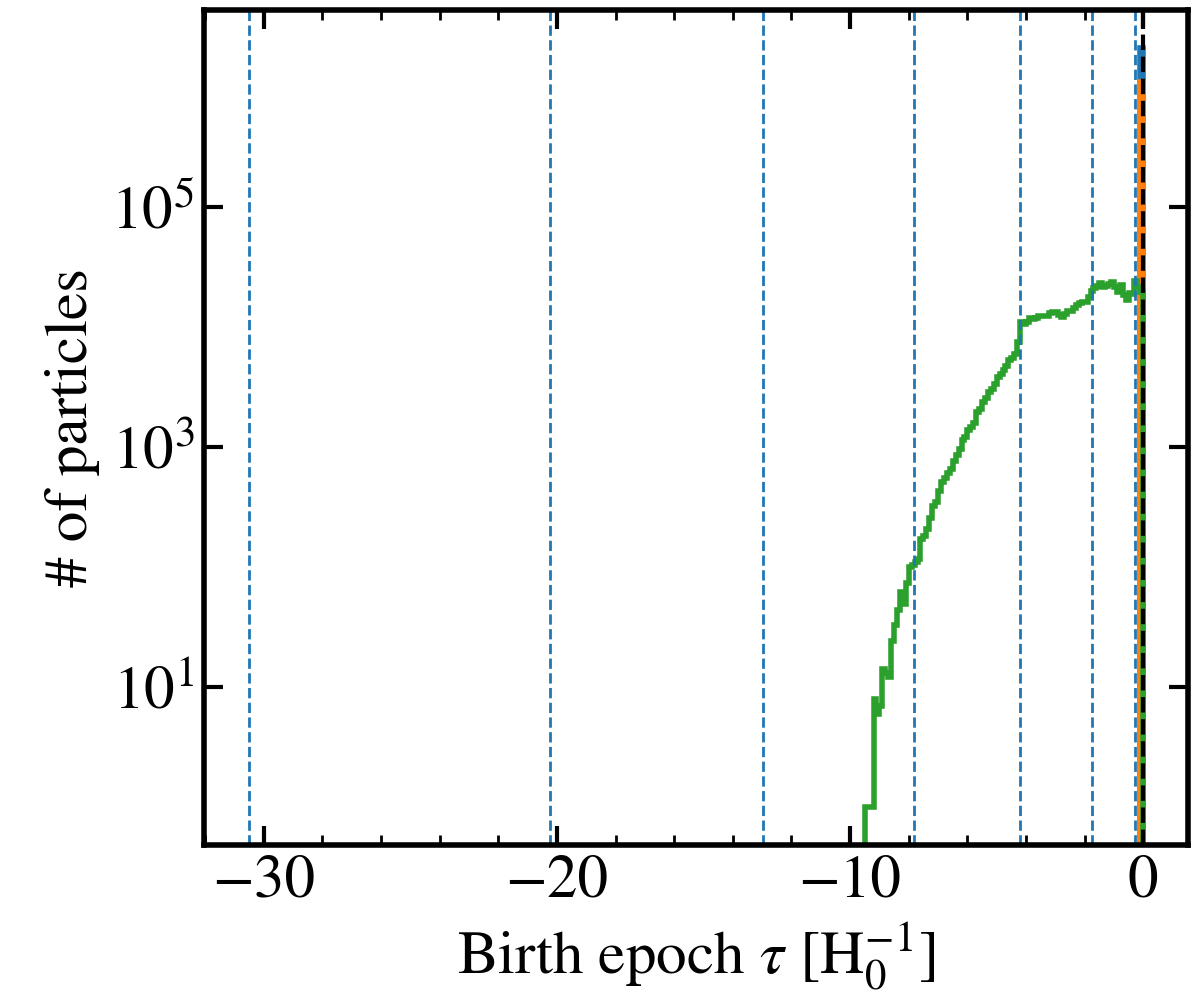

In [42]:
plt.subplots(figsize=(6, 5))

bins = np.linspace(-10, 0, 101)
args = dict(bins=bins, histtype="step", lw=2)
plt.hist(tc_birth[dm], **args)
plt.hist(tc_birth[bh], **args)
plt.hist(tc_birth[star], **args)

for tau in tau_refine:
    plt.axvline(-tau, ls="--", lw=1)

plt.axvline(info['time'], ls="--", c='k') # age of the Universe at this snapshot
plt.yscale('log')
plt.xlabel(r"Birth epoch $\tau$ [H$_0^{-1}$]")
plt.ylabel("# of particles")
plt.subplots_adjust(bottom=0.155, left=0.17, top=0.99, right=0.99)

From the HR5 paper (caption in Table 1),
> In addition, $M_{seed}^{BH} = 10^4 M_\odot$, $M_{DM} = 6.9 \times 10^7 M_\odot$ for the fineast DM particles, and the maximal spatial resolution $\approx 1 kpc$.

In [43]:
masses[dm] * unit_m # slightly diff from the number in the paper

array([63951357.33703188, 63951357.33703188, 63951357.33703188, ...,
       63951357.33703188, 63951357.33703188, 63951357.33703188])

In [44]:
masses[bh] * unit_m # 4.93? Why are there so small values?

array([2212.82575321,    4.93481056,  888.69906634, ...,   14.4138335 ,
          4.94773191,    4.93839367])

In [45]:
mstar = masses[star] * unit_m

In [46]:
mstar.min(), mstar.max()

(1470449.1315126976, 16236425.34705429)

<IPython.core.display.Javascript object>


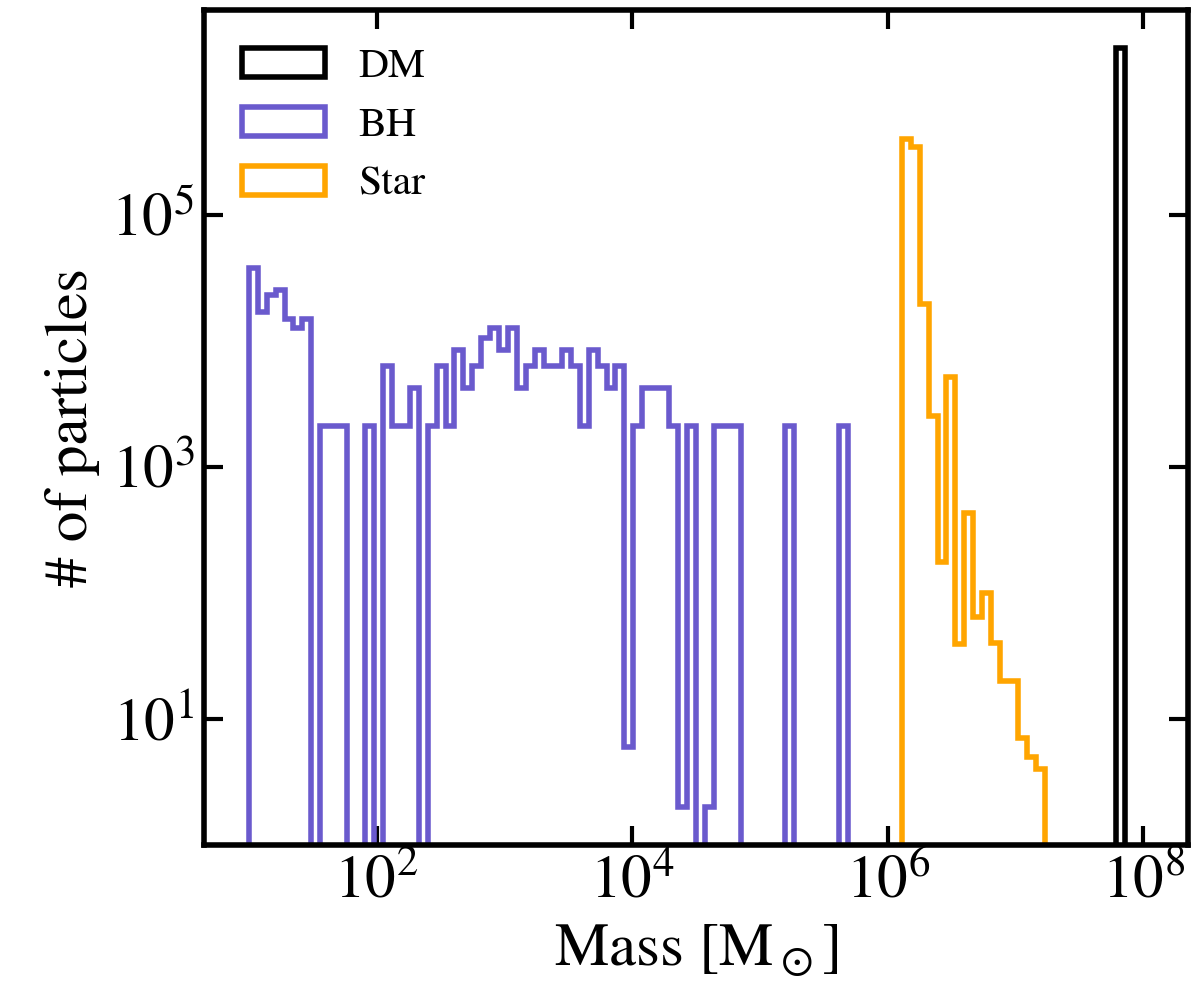

In [47]:
plt.subplots(figsize=(6, 5))

bins = np.logspace(1, 8, 101)
args = dict(bins=bins, histtype="step", lw=2)
plt.hist(masses[dm] * unit_m, ec='k', **args, label="DM")
plt.hist(masses[bh] * unit_m, ec='slateblue', **args, label="BH")
plt.hist(masses[star] * unit_m, ec='orange', **args, label="Star")

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"Mass [M$_\odot$]")
plt.ylabel("# of particles")
plt.legend(fontsize=15, frameon=False)
plt.subplots_adjust(bottom=0.155, left=0.17, top=0.99, right=0.99)

In [66]:
hist[0] / c_Lbox_Mpc**3

array([1210935.94263629, 1142413.25280435, 1149801.89375314,
       1082661.05516204, 1035727.52574519,  934691.36951973,
        909695.61594366,  952688.91605607,  968281.46520591,
       1003136.16629739, 1054380.93304073, 1087763.81357763,
       1227133.60087491, 1417201.37163587, 1586013.89751642,
       1609787.4718825 , 1795543.42834274, 1531901.84984801,
       1495605.71381208, 1557183.28558022, 1251130.58535448,
       1346049.23690688, 1327410.99912645, 1478554.51366248,
       1354583.97747508, 1319487.57976835, 1451342.80227859,
       1565661.01527952, 1555794.92409223, 1538307.87118184,
       1476471.28074361, 1443839.58421405, 1521885.77245611,
       1516295.00449979, 1462016.02614066, 1526172.57679217,
       1899085.04483134, 1994866.92266998, 2088069.73125517,
       2526372.23808617, 2368837.2960553 , 2489607.96935754,
       2347737.47662791, 2365474.69659415, 2243786.1216518 ,
       2582156.96533977, 2846601.48004461, 3004260.88200625,
       3211682.87550148,

In [83]:
bin_face = np.linspace(0, 1.1*unit_t, 101)
bin_cent = 0.5 * (bin_face[:-1] + bin_face[1:])
dt = np.diff(bin_face)[0] * 1e9 # yr

<IPython.core.display.Javascript object>


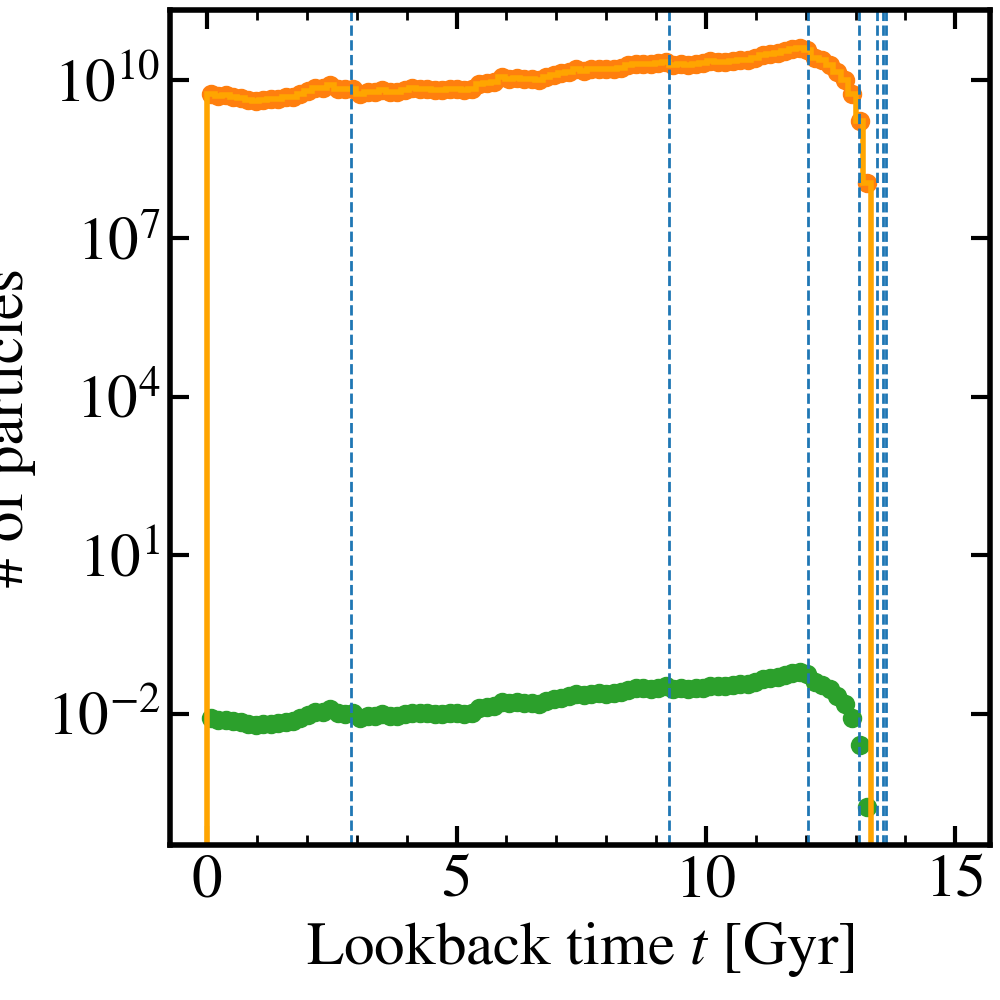

Text(0, 0.5, '# of particles')

In [84]:
plt.subplots(figsize=(5, 5))
args = dict(bins=np.linspace(0, 1.1*unit_t, 101), histtype="step", lw=2, ec='orange')
hist = plt.hist(-tp_birth[star] * unit_t, weights=masses[star] * unit_m,
                **args)

plt.scatter(bin_cent, hist[0])
plt.scatter(bin_cent, hist[0] / c_Lbox_Mpc**3 / np.diff(bin_face) / 1e9)

for t in t_refine:
    plt.axvline(t*unit_t, ls="--", lw=1)

plt.yscale('log')
plt.subplots_adjust(bottom=0.155, left=0.17, top=0.99, right=0.99)
plt.xlabel(r"Lookback time $t$ [Gyr]")
plt.ylabel("# of particles")

**I should match the unit of y axis to [Msun / yr / Mpc^3]**

# Behroozi 2014

In [60]:
!ls /md/gilee/cosmos-in-us/Multiverse-utils/notebooks/read_particle/behroozi/behroozi-2013-data-compilation/

csfrs_new.dat  DATA_README  smf_ms  ssfr


In [61]:
basePath

'/md/gilee/cosmos-in-us/Multiverse-utils/notebooks/read_particle/lmin07-hr5-32-01-grammar/output_00101'

In [62]:
with open(basePath+"/../../behroozi/behroozi-2013-data-compilation/csfrs_new.dat") as file:
    lines = file.readlines()
lines

['#zlow: 0.05\n',
 '#zhigh: 8.5\n',
 '#type: csfr\n',
 '2.2 -0.74416 0.19 0.19\n',
 '0.2 -1.75 0.13 0.13\n',
 '0.47 -1.62 0.13 0.13\n',
 '0.75 -1.41 0.13 0.13\n',
 '1.1 -1.25 0.17 0.17\n',
 '0.3 -1.75 0.13 0.13\n',
 '0.5 -1.63 0.13 0.13\n',
 '0.7 -1.37 0.13 0.13\n',
 '0.9 -1.33 0.17 0.17\n',
 '1.1 -1.15 0.17 0.17\n',
 '1.3 -1.05 0.17 0.17\n',
 '1.5 -0.93 0.17 0.17\n',
 '1.7 -1 0.19 0.19\n',
 '1.9 -1.05 0.19 0.19\n',
 '2.25 -1.23 0.19 0.19\n',
 '2.75 -1.23 0.19 0.19\n',
 '3.25 -1.45 0.27 0.27\n',
 '3.8 -1.95 0.27 0.27\n',
 '0.75 -1.22012189825617 0.13 0.13\n',
 '1.25 -1.15361632918473 0.17 0.17\n',
 '2 -1.02361632918473 0.19 0.19\n',
 '3 -1.0787927454597 0.27 0.27\n',
 '3.8 -1.31 0.27 0.27\n',
 '5.0 -1.71 0.27 0.27\n',
 '5.9 -1.92 0.27 0.27\n',
 '6.8 -2.14 0.27 0.27\n',
 '8.0 -2.37 0.27 0.27\n',
 '0.3 -1.72124639904717 0.13 0.13\n',
 '0.5 -1.60205999132796 0.13 0.13\n',
 '0.7 -1.36653154442041 0.13 0.13\n',
 '0.9 -1.23657200643706 0.17 0.17\n',
 '1.1 -1.13667713987954 0.17 0.17\n',
 '1.

In [63]:
behroozi = pd.read_csv(basePath+"/../../behroozi/behroozi-2013-data-compilation/csfrs_new.dat", skiprows=3, names=['z', 'log10_CSFR', 'err+', 'err-'], delim_whitespace=" ")

In [87]:
np.all(np.diff(table['t']) > 0)

True

In [99]:
tp_face = np.linspace(0, 1.1, 101)
tp_cent = 0.5 * (tp_face[:-1] + tp_face[1:])
a_itp = np.interp(tp_cent, table['t'], table['a'])

In [100]:
a_itp

array([0.99450921, 0.9835823 , 0.9727272 , 0.96194257, 0.95122707,
       0.94057937, 0.9299981 , 0.91948191, 0.90902946, 0.89863935,
       0.88831024, 0.87804072, 0.86782943, 0.85767495, 0.84757589,
       0.83753081, 0.8275383 , 0.81759693, 0.80770523, 0.79786174,
       0.78806497, 0.77831344, 0.76860563, 0.75894   , 0.74931504,
       0.73972914, 0.73018074, 0.7206682 , 0.71118991, 0.70174418,
       0.69232936, 0.6829437 , 0.67358546, 0.66425287, 0.6549441 ,
       0.6456573 , 0.63639057, 0.62714198, 0.61790954, 0.60869123,
       0.59948496, 0.5902886 , 0.58109995, 0.57191674, 0.56273663,
       0.55355724, 0.54437607, 0.53519055, 0.52599802, 0.51679573,
       0.50758082, 0.49835029, 0.48910102, 0.4798298 , 0.47053318,
       0.46120763, 0.45184944, 0.44245464, 0.43301905, 0.42353835,
       0.41400785, 0.40442262, 0.39477736, 0.38506658, 0.37528404,
       0.36542345, 0.35547773, 0.3454393 , 0.33529986, 0.32505045,
       0.3146813 , 0.30418134, 0.29353833, 0.28273906, 0.27176

In [101]:
z_itp = 1/a_itp - 1

In [102]:
z_itp

array([5.52110675e-03, 1.66917431e-02, 2.80374644e-02, 3.95631020e-02,
       5.12736951e-02, 6.31745030e-02, 7.52710168e-02, 8.75689730e-02,
       1.00074363e-01, 1.12793467e-01, 1.25732833e-01, 1.38899343e-01,
       1.52300170e-01, 1.65942879e-01, 1.79835358e-01, 1.93985920e-01,
       2.08403284e-01, 2.23096564e-01, 2.38075434e-01, 2.53349989e-01,
       2.68930904e-01, 2.84829406e-01, 3.01057343e-01, 3.17627211e-01,
       3.34552152e-01, 3.51846167e-01, 3.69523932e-01, 3.87601109e-01,
       4.06094197e-01, 4.25020720e-01, 4.44399248e-01, 4.64249551e-01,
       4.84592611e-01, 5.05450772e-01, 5.26847860e-01, 5.48809250e-01,
       5.71362071e-01, 5.94535252e-01, 6.18359855e-01, 6.42869069e-01,
       6.68098554e-01, 6.94086574e-01, 7.20874344e-01, 7.48506268e-01,
       7.77030210e-01, 8.06497908e-01, 8.36965387e-01, 8.68493371e-01,
       9.01147833e-01, 9.35000499e-01, 9.70129594e-01, 1.00662068e+00,
       1.04456741e+00, 1.08407229e+00, 1.12524863e+00, 1.16822083e+00,
      

<IPython.core.display.Javascript object>


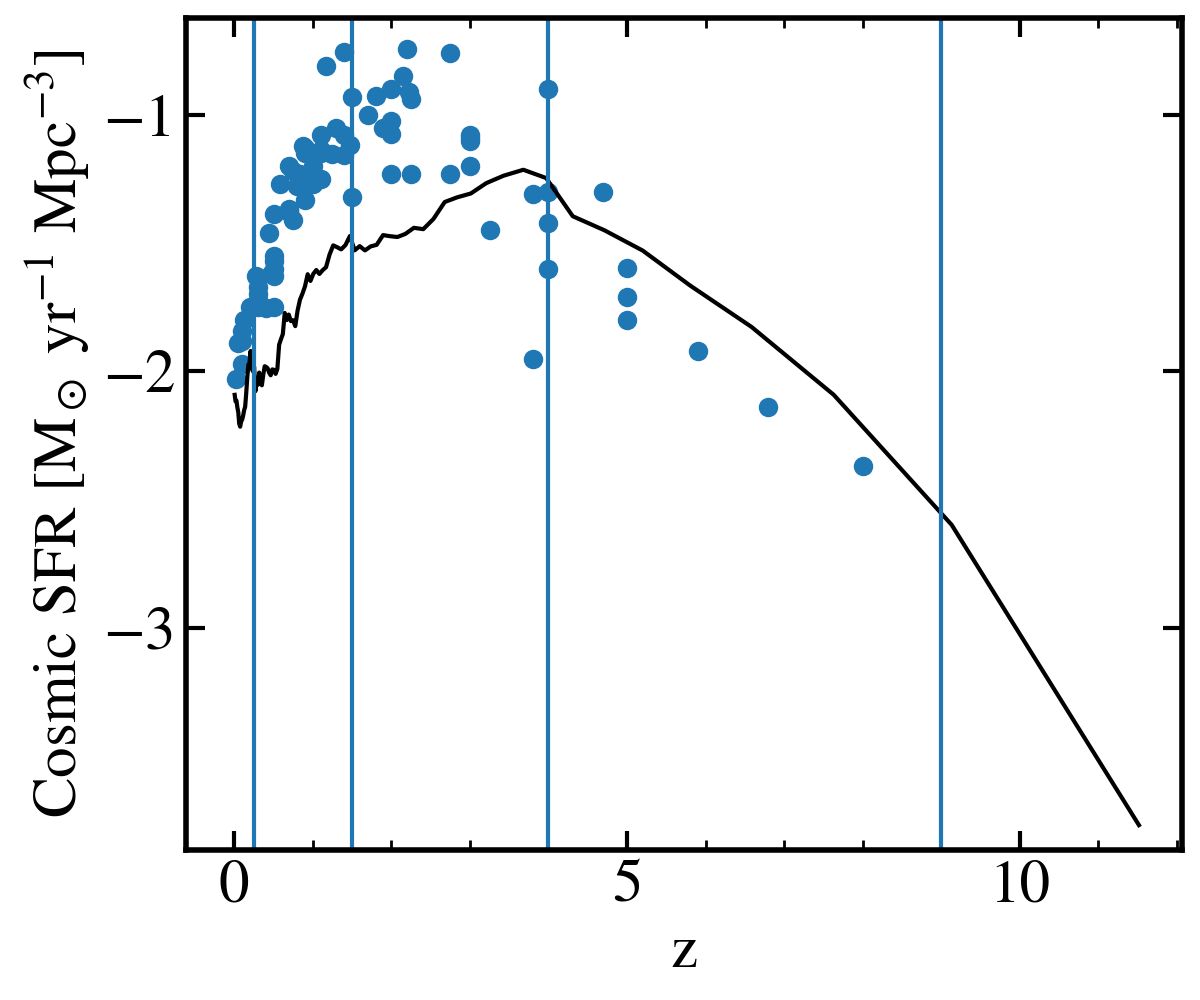

/tmp/ipykernel_1779382/4056313373.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(z_itp, np.log10(hist[0] / c_Lbox_Mpc**3 / np.diff(bin_face) / 1e9), c='k')


In [110]:
plt.figure(figsize=(6, 5))
plt.scatter(behroozi['z'], behroozi['log10_CSFR'])
plt.plot(z_itp, np.log10(hist[0] / c_Lbox_Mpc**3 / np.diff(bin_face) / 1e9), c='k')

for z in z_refine:
    plt.axvline(z)

plt.xlim(-1, 14)
plt.xlabel("z")
plt.ylabel(r"Cosmic SFR [M$_\odot$ yr$^{-1}$ Mpc$^{-3}$]")
plt.tight_layout(pad=0.3)